# A guide to finding the right neighbourhood in a new (unknown) city...

1. Introduction
2. Data Sources
3. How is the analysis done?
4. My personal goals

### 1. Introduction:

The world is on the move! In these times people have become quite flexible. It is common to go to a different country to start a new job. **But how do you find the right neighbourhood in a city you do not know?**

Well, you certainly know the neighbourhoods in the city in which you are currently living. You know which mix of **features** (shopping, restaurants, entertainment, green parks, public transport, education...) you are looking for. Thus you can provide **a point of reference** to find the right place somewhere else. And since you are not familiar with the new city you might be particularly concerned about safety and housing prices.

Again, Toronto will serve as the city of interest. A neighbourhood in Zurich, Switzerland, will be the point of reference. Obviously both choices (origin & destination) are exchangeable.

**Problem:** *Find feasible neighbourhoods in Toronto based on your preferences?*

### 2. Data Sources

The analysis will make use of different data sources:
* Foursquare-API venue data to derive the neighborhood's features
* List of neighbourhoods and housing prices from Toronto's 'Open Data Portal': https://open.toronto.ca/
* Crime statistics using Toronto's 'Police Service Open Data Portal': http://data.torontopolice.on.ca/pages/open-data



### 3. How is the analysis done?

Without going in too much detail the analysis will perform following steps:
* (A) Perform a preselection of neighbourhoods in Toronto based on crime rates and housing prices.
* (B) Derive the characteristics of the Zurich neighbourhood (point of reference) with help of Foursquare-API.
* (C) Similarly build a table of feature vectors (columns) for the Toronto neighbourhoods using Foursquare-API. 
* (D) Define and add variations of the Zurich neighbourhood (eg more 'nightlife').
* (E) Use k-means clustering to find similar (with respect to the point of reference) neighbourhoods in Toronto.
* (F) Results

Generally: Make extensive use of visualisations & tables to show the findings of the analysis. **Be transparent and make the results comprehensible!**

### 4. My personal goals


Since this is the final step in the IBM Data Science specialization I will take the freedom to prioritize my learning goals in this project. There are particularly 3 topics I would like to get a better understanding of:
* Explore the spectrum of data made available by Foursquare-API 
* Investigate how sensitive the k-means-algorithm performs to changes in data input
* Deepen the knowledge in visualizing results

With this in mind I will use some code of my week 3 assignment rather than completely *re-invent* the wheel ;-)

## (A) Preselection of neighbourhoods

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 100)  
pd.set_option('display.max_rows', 250)  

%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt

When moving to an unknown place you are particularly concerned about safety and affordability. Let's start the analysis by building up a list of Toronto neighbourhoods with crime rates and housing prices. All files are publicly available!

In [2]:
df_neigh = pd.read_csv(r'C:\Users\peter\Documents\GitHub\Coursera_Capstone-master\toronto_neighbourhoods.csv')  
df_neigh.head(2)

,_id,AREA_ID,AREA_ATTR_ID,PARENT_AREA_ID,AREA_SHORT_CODE,AREA_LONG_CODE,AREA_NAME,AREA_DESC,X,Y,LONGITUDE,LATITUDE,OBJECTID,Shape__Area,Shape__Length,geometry
0,4761,25886861,25926662,49885,94,94,Wychwood (94),Wychwood (94),NaN,NaN,-79.425515,43.676919,16491505,3.217960e+06,7515.779658,"{u'type': u'Polygon', u'coordinates': (((-79.4..."
1,4762,25886820,25926663,49885,100,100,Yonge-Eglinton (100),Yonge-Eglinton (100),NaN,NaN,-79.403590,43.704689,16491521,3.160334e+06,7872.021074,"{u'type': u'Polygon', u'coordinates': (((-79.4..."


In [3]:
df_neigh1 = df_neigh.loc[:, ['AREA_NAME', 'AREA_SHORT_CODE', 'LONGITUDE', 'LATITUDE' ]].sort_values('AREA_SHORT_CODE')
df_neigh1.head()

,AREA_NAME,AREA_SHORT_CODE,LONGITUDE,LATITUDE
63,West Humber-Clairville (1),1,-79.596356,43.716180
20,Mount Olive-Silverstone-Jamestown (2),2,-79.587259,43.746868
56,Thistletown-Beaumond Heights (3),3,-79.563491,43.737988
40,Rexdale-Kipling (4),4,-79.566228,43.723725
112,Elms-Old Rexdale (5),5,-79.548983,43.721519


In [4]:
df_crime = pd.read_csv(r'C:\Users\peter\Documents\GitHub\Coursera_Capstone-master\toronto_crime.csv')  
df_crime.head()

,OBJECTID,Neighbourhood,Hood_ID,Population,Assault_2019,AutoTheft_2019,BreakandEnter_2019,Homicide_2019,Robbery_2019,TheftOver_2019,Shape__Area,Shape__Length
0,1,Yonge-St.Clair,97,12528,37,6,28,0,4,6,1.161315e+06,5873.270582
1,2,York University Heights,27,27593,370,144,108,0,79,28,1.324666e+07,18504.777330
2,3,Lansing-Westgate,38,16164,72,32,39,0,11,11,5.346186e+06,11112.109620
3,4,Yorkdale-Glen Park,31,14804,209,61,84,1,42,29,6.038326e+06,10079.426920
4,5,Stonegate-Queensway,16,25051,82,34,64,0,22,4,7.946202e+06,11853.189880


In [5]:
df_crime1 = df_crime.loc[:, ['Neighbourhood', 'Hood_ID' ]]

Now derive an average crime rate based on the different types of crime. To be precise, I defined it as the sum of crimes divided by the population of the neighbourhood.

In [6]:
df_crime1['crime_rate'] = df_crime.apply(lambda r: (r.Assault_2019 + r.AutoTheft_2019 + r.Robbery_2019 + r.TheftOver_2019) / r.Population, axis=1)

In [7]:
df_crime1.sort_values('Hood_ID').head()

,Neighbourhood,Hood_ID,crime_rate
41,West Humber-Clairville,1,0.026417
98,Mount Olive-Silverstone-Jamestown,2,0.012745
7,Thistletown-Beaumond Heights,3,0.012934
103,Rexdale-Kipling,4,0.013107
78,Elms-Old Rexdale,5,0.011950


In [8]:
df_hprice = pd.read_csv(r'C:\Users\peter\Documents\GitHub\Coursera_Capstone-master\toronto_housing_prices.csv')  
df_hprice.head()

,Neighbourhood,Neighbourhood Id,Home Prices
0,West Humber-Clairville,1,317508
1,Mount Olive-Silverstone-Jamestown,2,251119
2,Thistletown-Beaumond Heights,3,414216
3,Rexdale-Kipling,4,392271
4,Elms-Old Rexdale,5,233832


Ok, now we are ready to join the 3 dataframes

In [9]:
df_toronto1= pd.merge(df_neigh1, df_crime1, left_on='AREA_SHORT_CODE', right_on='Hood_ID')
df_hprice.rename(columns={'Neighbourhood Id': 'Hood_ID'}, inplace=True)
df_toronto2= pd.merge(df_toronto1, df_hprice, on='Hood_ID', how='left')
df_toronto2.head()

,AREA_NAME,AREA_SHORT_CODE,LONGITUDE,LATITUDE,Neighbourhood_x,Hood_ID,crime_rate,Neighbourhood_y,Home Prices
0,West Humber-Clairville (1),1,-79.596356,43.716180,West Humber-Clairville,1,0.026417,West Humber-Clairville,317508
1,Mount Olive-Silverstone-Jamestown (2),2,-79.587259,43.746868,Mount Olive-Silverstone-Jamestown,2,0.012745,Mount Olive-Silverstone-Jamestown,251119
2,Thistletown-Beaumond Heights (3),3,-79.563491,43.737988,Thistletown-Beaumond Heights,3,0.012934,Thistletown-Beaumond Heights,414216
3,Rexdale-Kipling (4),4,-79.566228,43.723725,Rexdale-Kipling,4,0.013107,Rexdale-Kipling,392271
4,Elms-Old Rexdale (5),5,-79.548983,43.721519,Elms-Old Rexdale,5,0.011950,Elms-Old Rexdale,233832


In [10]:
df_toronto2 = df_toronto2.drop(df_toronto2.columns[[1, 4, 5, 7]], axis=1)
df_toronto2['crime_rate']=df_toronto2['crime_rate']*100
df_toronto2['Home Prices']=df_toronto2['Home Prices']/1000
df_toronto2.head()

,AREA_NAME,LONGITUDE,LATITUDE,crime_rate,Home Prices
0,West Humber-Clairville (1),-79.596356,43.716180,2.641691,317.508
1,Mount Olive-Silverstone-Jamestown (2),-79.587259,43.746868,1.274504,251.119
2,Thistletown-Beaumond Heights (3),-79.563491,43.737988,1.293436,414.216
3,Rexdale-Kipling (4),-79.566228,43.723725,1.310666,392.271
4,Elms-Old Rexdale (5),-79.548983,43.721519,1.195008,233.832


In [11]:
df_toronto3 = df_toronto2.drop(['LONGITUDE','LATITUDE'], axis=1)

That is the data set we will for the preselection. Let's have a first look at the statistics.

In [12]:
df_toronto3.describe()

,crime_rate,Home Prices
count,140.000000,140.000000
mean,1.069860,548.193407
std,0.643798,267.667427
min,0.365512,204.104000
25%,0.652040,374.964500
50%,0.958526,491.210000
75%,1.242825,590.216000
max,4.504400,1849.084000


By the way: Is there a connection between Home Prices and Crime Rate?

In [13]:
x = df_toronto2['Home Prices']      
y = df_toronto2['crime_rate']     
fit = np.polyfit(x, y, deg=1)

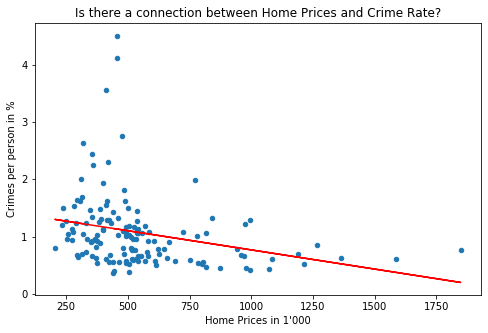

In [14]:
ax = df_toronto2.plot(kind='scatter', x='Home Prices', y='crime_rate', figsize=(8, 5) )

ax.set_title('Is there a connection between Home Prices and Crime Rate?')
ax.set_ylabel('Crimes per person in %')
ax.set_xlabel("Home Prices in 1'000")
plt.plot(x, fit[0] * x + fit[1], color='red')

Is looks a bit like that. But there are lots of save neighbourhoods which are affordable!

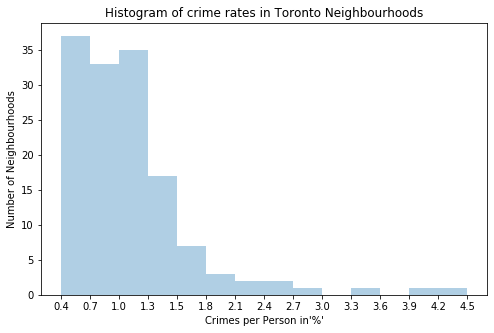

In [15]:
count, bin_edges = np.histogram(df_toronto2['crime_rate'], 14)

ax = df_toronto2['crime_rate'].plot(kind='hist', alpha=0.35, figsize=(8, 5), bins=14, xticks=bin_edges, )
ax.set_title('Histogram of crime rates in Toronto Neighbourhoods')
ax.set_ylabel('Number of Neighbourhoods')
ax.set_xlabel("Crimes per Person in'%'" )
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.1f}'))

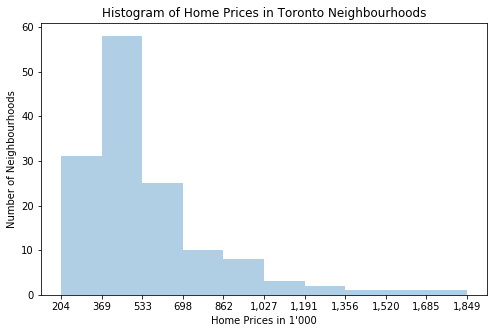

In [16]:
count, bin_edges = np.histogram(df_toronto2['Home Prices'], 10)

ax = df_toronto2['Home Prices'].plot(kind='hist', alpha=0.35, figsize=(8, 5), bins=10, xticks=bin_edges, )

ax.set_title('Histogram of Home Prices in Toronto Neighbourhoods')
ax.set_ylabel('Number of Neighbourhoods')
ax.set_xlabel("Home Prices in 1'000")

ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

Ok, let's narrow the neighbourhoods down to the safer half, ie. crime rate < 1%

In [17]:
df_toronto_adj_crime=df_toronto2[df_toronto2['crime_rate'] < 1].reset_index(drop=True)
df_toronto_adj_crime.head()

,AREA_NAME,LONGITUDE,LATITUDE,crime_rate,Home Prices
0,Kingsview Village-The Westway (6),-79.547863,43.698993,0.672727,292.861
1,Willowridge-Martingrove-Richview (7),-79.554221,43.683645,0.803394,511.637
2,Humber Heights-Westmount (8),-79.522416,43.692233,0.566313,491.396
3,Edenbridge-Humber Valley (9),-79.522458,43.670886,0.444158,873.268
4,Princess-Rosethorn (10),-79.544559,43.666051,0.669623,971.668


And next we choose 600'000 as the maximum home price

In [18]:
df_toronto_adj=df_toronto_adj_crime[df_toronto_adj_crime['Home Prices'] < 600].reset_index(drop=True)
df_toronto_adj.head()

,AREA_NAME,LONGITUDE,LATITUDE,crime_rate,Home Prices
0,Kingsview Village-The Westway (6),-79.547863,43.698993,0.672727,292.861
1,Willowridge-Martingrove-Richview (7),-79.554221,43.683645,0.803394,511.637
2,Humber Heights-Westmount (8),-79.522416,43.692233,0.566313,491.396
3,Eringate-Centennial-West Deane (11),-79.580445,43.658017,0.548741,423.034
4,Markland Wood (12),-79.573432,43.633542,0.388478,505.350


In [19]:
df_toronto_adj.shape

(47, 5)

In the end we got 47 of the original 144 neighbourhoods for further investigation. Where are they on the map?

In [20]:
import folium # map rendering library

In [21]:
t_latitude = 43.6529
t_longitude = -79.3849
t_name = 'Toronto' 

In [22]:
map_preselection = folium.Map(location=[t_latitude, t_longitude], zoom_start=10)

for lat, lng, neighborhood in zip(df_toronto_adj['LATITUDE'], df_toronto_adj['LONGITUDE'], df_toronto_adj['AREA_NAME']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_preselection)  
    
map_preselection

## (B) Derive the characteristics of the Zurich neighbourhood (point of reference) 

In [23]:
import requests 
from pandas.io.json import json_normalize
import json
from geopy.geocoders import Nominatim 

In [24]:
CLIENT_ID = 'xxx' 
CLIENT_SECRET = 'yyy' 
VERSION = '20180605' 

In [25]:
z_neighborhood_latitude = 47.3610447
z_neighborhood_longitude = 8.5230362
z_neighborhood_name = 'Zurich' 
LIMIT = 100

Basically I use the function we developed in the week 3 assignment. However...

...I decided that I will work with the main categories (there are 10 of them!) and not with the huge set of subcategories (nearly 300). This piece of information can be found deeply nested in the JSON-file. It is a part of the 'prefix'...

In [26]:
def getNearbyVenues(names, latitudes, longitudes, radius=800):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name, lat, lng)
            
        
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
                       
        results = requests.get(url).json()["response"]['groups'][0]['items']
                
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['icon']['prefix'].split('/')[-2]) for v in results])

    
    return(venues_list)

In [27]:
z_venues = getNearbyVenues(names=[z_neighborhood_name],
                                   latitudes=[z_neighborhood_latitude],
                                   longitudes=[z_neighborhood_longitude], 
                                   radius=800
                                  )

Zurich 47.3610447 8.5230362


In [28]:
z_venues

[[('Zurich',
   47.3610447,
   8.5230362,
   'Don Leone',
   47.36125720709889,
   8.526476484427297,
   'food'),
  ('Zurich',
   47.3610447,
   8.5230362,
   'Weisses Rössli',
   47.361770192099634,
   8.52623623893753,
   'food'),
  ('Zurich',
   47.3610447,
   8.5230362,
   'kai sushi Lessing',
   47.360041821792954,
   8.52364577800537,
   'food'),
  ('Zurich',
   47.3610447,
   8.5230362,
   'VBZ Sihlcity Nord',
   47.35978942773796,
   8.522695989034265,
   'travel'),
  ('Zurich',
   47.3610447,
   8.5230362,
   'B2 Boutique Hotel & Spa',
   47.3645315555875,
   8.52455073678241,
   'travel'),
  ('Zurich',
   47.3610447,
   8.5230362,
   'JOE & THE JUICE',
   47.358751,
   8.523082,
   'food'),
  ('Zurich',
   47.3610447,
   8.5230362,
   'Four Points by Sheraton Sihlcity',
   47.35919893698425,
   8.52314293384552,
   'travel'),
  ('Zurich',
   47.3610447,
   8.5230362,
   'Thermalbad & Spa',
   47.36470347529419,
   8.52534182877817,
   'shops'),
  ('Zurich', 47.3610447, 8.5230

In [59]:
z_df = pd.DataFrame([venue_set for neigh in z_venues for venue_set in neigh])
z_df.columns = ['Neighbourhood', 'N_lat', 'N_long', 'Venue', 'V_lat', 'V_long', 'Main_Category']
z_df

,Neighbourhood,N_lat,N_long,Venue,V_lat,V_long,Main_Category
0,Zurich,47.361045,8.523036,Don Leone,47.361257,8.526476,food
1,Zurich,47.361045,8.523036,Weisses Rössli,47.361770,8.526236,food
2,Zurich,47.361045,8.523036,kai sushi Lessing,47.360042,8.523646,food
3,Zurich,47.361045,8.523036,VBZ Sihlcity Nord,47.359789,8.522696,travel
4,Zurich,47.361045,8.523036,B2 Boutique Hotel & Spa,47.364532,8.524551,travel
5,Zurich,47.361045,8.523036,JOE & THE JUICE,47.358751,8.523082,food
6,Zurich,47.361045,8.523036,Four Points by Sheraton Sihlcity,47.359199,8.523143,travel
7,Zurich,47.361045,8.523036,Thermalbad & Spa,47.364703,8.525342,shops
8,Zurich,47.361045,8.523036,Yalda,47.358006,8.522914,food
9,Zurich,47.361045,8.523036,Restaurant Hopfenau,47.365205,8.519986,food


How are the (main) categories in the Zurich neighbourhood distributed?

In [60]:
z_df.groupby('Main_Category').count()

,Neighbourhood,N_lat,N_long,Venue,V_lat,V_long
Main_Category,,,,,,
arts_entertainment,5,5,5,5,5,5
building,2,2,2,2,2,2
food,42,42,42,42,42,42
nightlife,5,5,5,5,5,5
parks_outdoors,5,5,5,5,5,5
shops,18,18,18,18,18,18
travel,10,10,10,10,10,10


Ok, let's prepare a dataframe for the cluster analysis

In [61]:
z_onehot = pd.get_dummies(z_df[['Main_Category']], prefix="", prefix_sep="")
neigh_col = z_df['Neighbourhood']
z_onehot.insert(loc=0, column='Neighbourhood', value=neigh_col)
z_onehot

,Neighbourhood,arts_entertainment,building,food,nightlife,parks_outdoors,shops,travel
0,Zurich,0,0,1,0,0,0,0
1,Zurich,0,0,1,0,0,0,0
2,Zurich,0,0,1,0,0,0,0
3,Zurich,0,0,0,0,0,0,1
4,Zurich,0,0,0,0,0,0,1
5,Zurich,0,0,1,0,0,0,0
6,Zurich,0,0,0,0,0,0,1
7,Zurich,0,0,0,0,0,1,0
8,Zurich,0,0,1,0,0,0,0
9,Zurich,0,0,1,0,0,0,0


In [62]:
z_features = z_onehot.groupby('Neighbourhood').mean().reset_index()
z_features.rename(columns={'arts_entertainment': 'arts', 'parks_outdoors': 'parks'}, inplace=True)
z_features

,Neighbourhood,arts,building,food,nightlife,parks,shops,travel
0,Zurich,0.057471,0.022989,0.482759,0.057471,0.057471,0.206897,0.114943


 Finally, the feature vector for Zürich! Our point or reference for the comparison to the Toronto Neighbourhoods.

## (C) Build a table of feature vectors for the Toronto neighbourhoods

Make sure to run the query only for the subset of 47 neighbourhoods

In [63]:
t_venues = getNearbyVenues(names=df_toronto_adj['AREA_NAME'],
                                   latitudes=df_toronto2['LATITUDE'],
                                   longitudes=df_toronto2['LONGITUDE'], 
                                   radius=1000
                                  )

Kingsview Village-The Westway (6) 43.7161804033 -79.59635645350001
Willowridge-Martingrove-Richview (7) 43.7468678027 -79.58725926460002
Humber Heights-Westmount (8) 43.737987917299996 -79.56349101720001
Eringate-Centennial-West Deane (11) 43.72372547720001 -79.5662284127
Markland Wood (12) 43.721518868400004 -79.54898271649999
Etobicoke West Mall (13) 43.69899257220001 -79.5478633059
Alderwood (20) 43.683644963 -79.5542210494
Maple Leaf (29) 43.6922328007 -79.5224162029
Brookhaven-Amesbury (30) 43.6708859094 -79.5224577643
Englemount-Lawrence (32) 43.666050604300004 -79.5445592919
Bathurst Manor (34) 43.6580167554 -79.5804452375
Westminster-Branson (35) 43.6335417462 -79.57343154739999
Victoria Village (43) 43.6450626244 -79.5689387722
Flemingdon Park (44) 43.6334633497 -79.5433165354
Parkwoods-Donalda (45) 43.6535204276 -79.5105768007
Pleasant View (46) 43.635518132899996 -79.50112821329998
Don Valley Village (47) 43.615923861300004 -79.5001366364
Hillcrest Village (48) 43.6005885981

In [64]:
t_venues

[[('Kingsview Village-The Westway (6)',
   43.7161804033,
   -79.59635645350001,
   'Fortinos',
   43.721438,
   -79.596291,
   'shops'),
  ('Kingsview Village-The Westway (6)',
   43.7161804033,
   -79.59635645350001,
   'Mandarin Buffet',
   43.7203596,
   -79.5943875,
   'food'),
  ('Kingsview Village-The Westway (6)',
   43.7161804033,
   -79.59635645350001,
   'Tim Hortons',
   43.71465748224628,
   -79.59371566772467,
   'food'),
  ('Kingsview Village-The Westway (6)',
   43.7161804033,
   -79.59635645350001,
   'Woodbine Racetrack',
   43.716673372932725,
   -79.6049620534349,
   'arts_entertainment'),
  ('Kingsview Village-The Westway (6)',
   43.7161804033,
   -79.59635645350001,
   'Bulk Barn',
   43.720289723938166,
   -79.60088657671135,
   'shops'),
  ('Kingsview Village-The Westway (6)',
   43.7161804033,
   -79.59635645350001,
   'Winners',
   43.7198189817913,
   -79.5949226617813,
   'shops'),
  ('Kingsview Village-The Westway (6)',
   43.7161804033,
   -79.59635645350

In [65]:
t_df = pd.DataFrame([venue_set for neigh in t_venues for venue_set in neigh])
t_df.columns = ['Neighbourhood', 'N_lat', 'N_long', 'Venue', 'V_lat', 'V_long', 'Main_Category']
t_df.head()

,Neighbourhood,N_lat,N_long,Venue,V_lat,V_long,Main_Category
0,Kingsview Village-The Westway (6),43.71618,-79.596356,Fortinos,43.721438,-79.596291,shops
1,Kingsview Village-The Westway (6),43.71618,-79.596356,Mandarin Buffet,43.720360,-79.594387,food
2,Kingsview Village-The Westway (6),43.71618,-79.596356,Tim Hortons,43.714657,-79.593716,food
3,Kingsview Village-The Westway (6),43.71618,-79.596356,Woodbine Racetrack,43.716673,-79.604962,arts_entertainment
4,Kingsview Village-The Westway (6),43.71618,-79.596356,Bulk Barn,43.720290,-79.600887,shops


In [66]:
t_onehot = pd.get_dummies(t_df[['Main_Category']], prefix="", prefix_sep="")
tneigh_col = t_df['Neighbourhood']
t_onehot.insert(loc=0, column='Neighbourhood', value=tneigh_col)
t_onehot.drop(['education'], axis=1, inplace=True)
t_onehot

,Neighbourhood,arts_entertainment,building,food,nightlife,parks_outdoors,shops,travel
0,Kingsview Village-The Westway (6),0,0,0,0,0,1,0
1,Kingsview Village-The Westway (6),0,0,1,0,0,0,0
2,Kingsview Village-The Westway (6),0,0,1,0,0,0,0
3,Kingsview Village-The Westway (6),1,0,0,0,0,0,0
4,Kingsview Village-The Westway (6),0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...
1019,Guildwood (140),0,0,1,0,0,0,0
1020,Guildwood (140),0,0,0,0,0,1,0
1021,Guildwood (140),0,0,0,0,0,0,1
1022,Guildwood (140),0,0,1,0,0,0,0


In [67]:
t_features = t_onehot.groupby('Neighbourhood').mean().reset_index()
t_features.rename(columns={'arts_entertainment': 'arts', 'parks_outdoors': 'parks'}, inplace=True)
t_features.head()

,Neighbourhood,arts,building,food,nightlife,parks,shops,travel
0,Agincourt North (129),0.021739,0.000000,0.565217,0.000000,0.065217,0.326087,0.021739
1,Agincourt South-Malvern West (128),0.000000,0.200000,0.400000,0.000000,0.100000,0.100000,0.100000
2,Alderwood (20),0.000000,0.000000,0.400000,0.040000,0.000000,0.480000,0.080000
3,Bathurst Manor (34),0.083333,0.041667,0.333333,0.041667,0.250000,0.208333,0.000000
4,Bayview Village (52),0.040000,0.040000,0.200000,0.040000,0.200000,0.440000,0.040000


In [68]:
t_features.describe()

,arts,building,food,nightlife,parks,shops,travel
count,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000
mean,0.023717,0.028593,0.408044,0.024782,0.155942,0.314057,0.036795
std,0.039995,0.048105,0.170352,0.033404,0.193621,0.138300,0.049247
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.303846,0.000000,0.033516,0.209430,0.000000
50%,0.000000,0.000000,0.400000,0.000000,0.086957,0.326087,0.021739
75%,0.039231,0.054887,0.544408,0.042572,0.200000,0.403882,0.056349
max,0.147059,0.200000,0.833333,0.153846,0.857143,0.642857,0.210526


## (D) Define and add variations of the Zurich neighbourhood (eg more 'nightlife')

Now let's use to knowledge of Zurich to define some variations of our current neighbourhood

In [69]:
z_features.loc[1] = ['Zurich_night',0.03, 0.02, 0.4, 0.2, 0.05, 0.2, 0.1]
z_features.loc[2] = ['Zurich_shop',0.05, 0.02, 0.35, 0.05, 0.05, 0.4, 0.08]
z_features.loc[3] = ['Zurich_art',0.2, 0.02, 0.3, 0.05, 0.15, 0.18, 0.1]
z_features

,Neighbourhood,arts,building,food,nightlife,parks,shops,travel
0,Zurich,0.057471,0.022989,0.482759,0.057471,0.057471,0.206897,0.114943
1,Zurich_night,0.030000,0.020000,0.400000,0.200000,0.050000,0.200000,0.100000
2,Zurich_shop,0.050000,0.020000,0.350000,0.050000,0.050000,0.400000,0.080000
3,Zurich_art,0.200000,0.020000,0.300000,0.050000,0.150000,0.180000,0.100000


[Text(0, 0, 'Zurich'),
 Text(0, 0, 'Zurich_night'),
 Text(0, 0, 'Zurich_shop'),
 Text(0, 0, 'Zurich_art')]

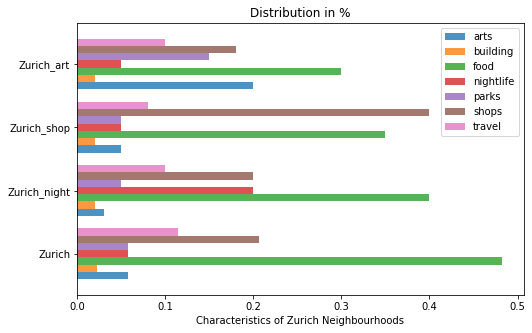

In [70]:
ax = z_features.plot(kind='barh', width=0.8, alpha=0.8, figsize=(8, 5), )

ax.set_title('Distribution in %')
ax.set_ylabel('')
ax.set_xlabel("Characteristics of Zurich Neighbourhoods")
ax.set_yticklabels(z_features['Neighbourhood'])

## (E) Use k-means clustering to find similar neighbourhoods in Toronto.

In [71]:
from sklearn.cluster import KMeans

In [72]:
df_features = z_features.append(t_features, ignore_index=True)
df_features.head(6)

,Neighbourhood,arts,building,food,nightlife,parks,shops,travel
0,Zurich,0.057471,0.022989,0.482759,0.057471,0.057471,0.206897,0.114943
1,Zurich_night,0.030000,0.020000,0.400000,0.200000,0.050000,0.200000,0.100000
2,Zurich_shop,0.050000,0.020000,0.350000,0.050000,0.050000,0.400000,0.080000
3,Zurich_art,0.200000,0.020000,0.300000,0.050000,0.150000,0.180000,0.100000
4,Agincourt North (129),0.021739,0.000000,0.565217,0.000000,0.065217,0.326087,0.021739
5,Agincourt South-Malvern West (128),0.000000,0.200000,0.400000,0.000000,0.100000,0.100000,0.100000


In [73]:
df_features_cluster = df_features.drop('Neighbourhood', axis=1)

In [74]:
kclusters = 4
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_features_cluster)

In [75]:
df_features.insert(1, 'Cluster Labels', kmeans.labels_)

In [76]:
df_features.head(4)

,Neighbourhood,Cluster Labels,arts,building,food,nightlife,parks,shops,travel
0,Zurich,1,0.057471,0.022989,0.482759,0.057471,0.057471,0.206897,0.114943
1,Zurich_night,1,0.030000,0.020000,0.400000,0.200000,0.050000,0.200000,0.100000
2,Zurich_shop,3,0.050000,0.020000,0.350000,0.050000,0.050000,0.400000,0.080000
3,Zurich_art,0,0.200000,0.020000,0.300000,0.050000,0.150000,0.180000,0.100000


Finally it is useful to show on the map how the different clusters are distributed. Thus we have to drop the Zurich Neighbourhoods and and geo-data for the Toronto neighbourhoods.

In [77]:
df_features.drop(df_features.index[[0,1,2,3]]).reset_index(drop=True)

,Neighbourhood,Cluster Labels,arts,building,food,nightlife,parks,shops,travel
0,Agincourt North (129),1,0.021739,0.000000,0.565217,0.000000,0.065217,0.326087,0.021739
1,Agincourt South-Malvern West (128),1,0.000000,0.200000,0.400000,0.000000,0.100000,0.100000,0.100000
2,Alderwood (20),3,0.000000,0.000000,0.400000,0.040000,0.000000,0.480000,0.080000
3,Bathurst Manor (34),0,0.083333,0.041667,0.333333,0.041667,0.250000,0.208333,0.000000
4,Bayview Village (52),0,0.040000,0.040000,0.200000,0.040000,0.200000,0.440000,0.040000
5,Briar Hill-Belgravia (108),0,0.000000,0.000000,0.153846,0.153846,0.384615,0.307692,0.000000
6,Broadview North (57),3,0.000000,0.062500,0.312500,0.062500,0.000000,0.500000,0.062500
7,Brookhaven-Amesbury (30),2,0.000000,0.000000,0.181818,0.000000,0.454545,0.181818,0.181818
8,Centennial Scarborough (133),3,0.052632,0.000000,0.315789,0.000000,0.052632,0.368421,0.210526
9,Danforth East York (59),0,0.000000,0.100000,0.300000,0.000000,0.200000,0.300000,0.100000


In [78]:
df_features.groupby('Cluster Labels').count()

,Neighbourhood,arts,building,food,nightlife,parks,shops,travel
Cluster Labels,,,,,,,,
0,10,10,10,10,10,10,10,10
1,19,19,19,19,19,19,19,19
2,5,5,5,5,5,5,5,5
3,17,17,17,17,17,17,17,17


In [79]:
df_toronto_clust= pd.merge(df_features, df_neigh1, left_on='Neighbourhood', right_on='AREA_NAME')
df_toronto_clust = df_toronto_clust.drop(['AREA_NAME','AREA_SHORT_CODE'], axis=1)
df_toronto_clust.head()

,Neighbourhood,Cluster Labels,arts,building,food,nightlife,parks,shops,travel,LONGITUDE,LATITUDE
0,Agincourt North (129),1,0.021739,0.000000,0.565217,0.000000,0.065217,0.326087,0.021739,-79.266712,43.805441
1,Agincourt South-Malvern West (128),1,0.000000,0.200000,0.400000,0.000000,0.100000,0.100000,0.100000,-79.265612,43.788658
2,Alderwood (20),3,0.000000,0.000000,0.400000,0.040000,0.000000,0.480000,0.080000,-79.541611,43.604937
3,Bathurst Manor (34),0,0.083333,0.041667,0.333333,0.041667,0.250000,0.208333,0.000000,-79.456055,43.764813
4,Bayview Village (52),0,0.040000,0.040000,0.200000,0.040000,0.200000,0.440000,0.040000,-79.377117,43.776361


In [80]:
df_toronto_clust0=df_toronto_clust[df_toronto_clust['Cluster Labels'] == 0]
df_toronto_clust0.head()

,Neighbourhood,Cluster Labels,arts,building,food,nightlife,parks,shops,travel,LONGITUDE,LATITUDE
3,Bathurst Manor (34),0,0.083333,0.041667,0.333333,0.041667,0.250000,0.208333,0.00,-79.456055,43.764813
4,Bayview Village (52),0,0.040000,0.040000,0.200000,0.040000,0.200000,0.440000,0.04,-79.377117,43.776361
5,Briar Hill-Belgravia (108),0,0.000000,0.000000,0.153846,0.153846,0.384615,0.307692,0.00,-79.452851,43.699024
9,Danforth East York (59),0,0.000000,0.100000,0.300000,0.000000,0.200000,0.300000,0.10,-79.331403,43.689468
12,Englemount-Lawrence (32),0,0.000000,0.111111,0.222222,0.000000,0.333333,0.333333,0.00,-79.437409,43.720345


In [81]:
df_toronto_clust1=df_toronto_clust[df_toronto_clust['Cluster Labels'] == 1]
df_toronto_clust1.head()

,Neighbourhood,Cluster Labels,arts,building,food,nightlife,parks,shops,travel,LONGITUDE,LATITUDE
0,Agincourt North (129),1,0.021739,0.0,0.565217,0.000000,0.065217,0.326087,0.021739,-79.266712,43.805441
1,Agincourt South-Malvern West (128),1,0.000000,0.2,0.400000,0.000000,0.100000,0.100000,0.100000,-79.265612,43.788658
10,Don Valley Village (47),1,0.068966,0.0,0.448276,0.068966,0.068966,0.310345,0.034483,-79.353644,43.783294
19,Hillcrest Village (48),1,0.062500,0.0,0.562500,0.031250,0.156250,0.187500,0.000000,-79.354804,43.802988
20,Humber Heights-Westmount (8),1,0.000000,0.0,0.631579,0.000000,0.157895,0.210526,0.000000,-79.522416,43.692233


In [82]:
df_toronto_clust2=df_toronto_clust[df_toronto_clust['Cluster Labels'] == 2]
df_toronto_clust2.head()

,Neighbourhood,Cluster Labels,arts,building,food,nightlife,parks,shops,travel,LONGITUDE,LATITUDE
7,Brookhaven-Amesbury (30),2,0.0,0.000000,0.181818,0.0,0.454545,0.181818,0.181818,-79.485589,43.701326
21,Ionview (125),2,0.0,0.000000,0.166667,0.0,0.500000,0.166667,0.000000,-79.272470,43.735364
24,L'Amoreaux (117),2,0.0,0.142857,0.000000,0.0,0.857143,0.000000,0.000000,-79.314084,43.795716
29,Mount Dennis (115),2,0.0,0.000000,0.250000,0.0,0.750000,0.000000,0.000000,-79.499989,43.688144
37,Steeles (116),2,0.0,0.000000,0.333333,0.0,0.500000,0.166667,0.000000,-79.321207,43.812959


In [83]:
df_toronto_clust3=df_toronto_clust[df_toronto_clust['Cluster Labels'] == 3]
df_toronto_clust3.head()

,Neighbourhood,Cluster Labels,arts,building,food,nightlife,parks,shops,travel,LONGITUDE,LATITUDE
2,Alderwood (20),3,0.000000,0.000000,0.400000,0.0400,0.000000,0.480000,0.080000,-79.541611,43.604937
6,Broadview North (57),3,0.000000,0.062500,0.312500,0.0625,0.000000,0.500000,0.062500,-79.355630,43.688825
8,Centennial Scarborough (133),3,0.052632,0.000000,0.315789,0.0000,0.052632,0.368421,0.210526,-79.150843,43.782376
11,Dovercourt-Wallace Emerson-Junction (93),3,0.000000,0.057143,0.457143,0.0000,0.028571,0.400000,0.057143,-79.438541,43.665677
13,Eringate-Centennial-West Deane (11),3,0.000000,0.000000,0.571429,0.0000,0.000000,0.428571,0.000000,-79.580445,43.658017


In [84]:
map_clusters = folium.Map(location=[t_latitude, t_longitude], zoom_start=10)

for lat, lng, neighbourhood in zip(df_toronto_clust0['LATITUDE'], df_toronto_clust0['LONGITUDE'], df_toronto_clust0['Neighbourhood']):
    label = '{}'.format(neighbourhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_clusters)  

for lat, lng, neighbourhood in zip(df_toronto_clust1['LATITUDE'], df_toronto_clust1['LONGITUDE'], df_toronto_clust1['Neighbourhood']):
    label = '{}'.format(neighbourhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_clusters)  
    
for lat, lng, neighbourhood in zip(df_toronto_clust2['LATITUDE'], df_toronto_clust2['LONGITUDE'], df_toronto_clust2['Neighbourhood']):
    label = '{}'.format(neighbourhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_clusters)
    
for lat, lng, neighbourhood in zip(df_toronto_clust3['LATITUDE'], df_toronto_clust3['LONGITUDE'], df_toronto_clust3['Neighbourhood']):
    label = '{}'.format(neighbourhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_clusters)    
    


## (F) Result... (a picture is worth a thousand words!)

In [85]:
map_clusters

Finally, the machine learning (ML) recommendation (see tables below for reference):
* GREEN: The biggest cluster. Zurich and Zurich_night have been attributed to it
* BLUE: According to ML, the neighbourhood most twisted to art, ie Zurich_art is assigned to this cluster
* RED: The red cluster points represent mainly parks
* YELLOW: Alike blue but more shops instead of parks, ie the Zurich_shop cluster

In [86]:
df_features.rename(columns={'Neighbourhood': 'NBH', 'Cluster Labels': 'Cluster'}, inplace=True)
df_features.head(4)

,NBH,Cluster,arts,building,food,nightlife,parks,shops,travel
0,Zurich,1,0.057471,0.022989,0.482759,0.057471,0.057471,0.206897,0.114943
1,Zurich_night,1,0.030000,0.020000,0.400000,0.200000,0.050000,0.200000,0.100000
2,Zurich_shop,3,0.050000,0.020000,0.350000,0.050000,0.050000,0.400000,0.080000
3,Zurich_art,0,0.200000,0.020000,0.300000,0.050000,0.150000,0.180000,0.100000


In [87]:
df_features.replace({'Cluster': {0: 'Green', 1: 'Blue', 2: 'Red', 3: 'Yellow'}}, inplace=True )
df_features.groupby('Cluster').mean()

,arts,building,food,nightlife,parks,shops,travel
Cluster,,,,,,,
Blue,0.032444,0.025082,0.549794,0.040512,0.073001,0.233499,0.040404
Green,0.046619,0.045563,0.247089,0.034107,0.248597,0.332538,0.041320
Red,0.000000,0.028571,0.186364,0.000000,0.612338,0.103030,0.036364
Yellow,0.021738,0.020696,0.403649,0.024200,0.041298,0.439445,0.044800


In [88]:
df_features.groupby('Cluster').count()

,NBH,arts,building,food,nightlife,parks,shops,travel
Cluster,,,,,,,,
Blue,19,19,19,19,19,19,19,19
Green,10,10,10,10,10,10,10,10
Red,5,5,5,5,5,5,5,5
Yellow,17,17,17,17,17,17,17,17
